# 2024-11-05

The SAR is alive! Got a ping from Sylvain started testing TinyTapeout 6.

- The SAR is doing something
- The CLK fall to DONE rise < 83 ns (sim 44 ns)
- Noise < 1.5 LSB

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import os
#os.chdir("meas")
df = pd.read_csv("sar.csv")
df["time"] = df["time"]/10
df["us"] = df["time"]/1000

In [8]:

df.set_index("time",inplace=True)
df["RLSB"] = 2**3*df["B3"] + 2**2*df["B2"] + 2**1*df["B1"] + 2**0*df["B0"]

13.329743164871582
1.4651174032449195


(100000.0, 200000.0)

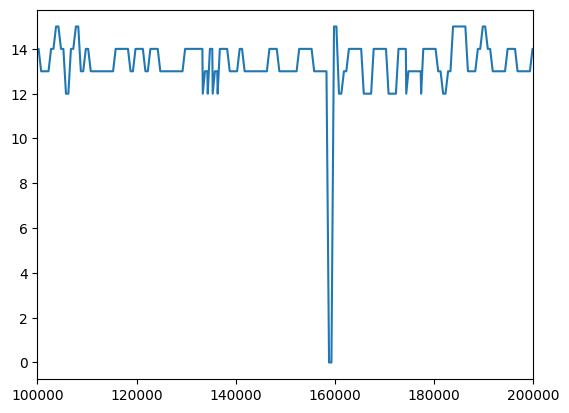

In [9]:
dfa = df[df["DONE"] < 0.5]
print(dfa["RLSB"].mean())
print(dfa["RLSB"].std())
plt.plot(dfa["RLSB"])

plt.xlim(100000,200000)

(10.0, 14.0)

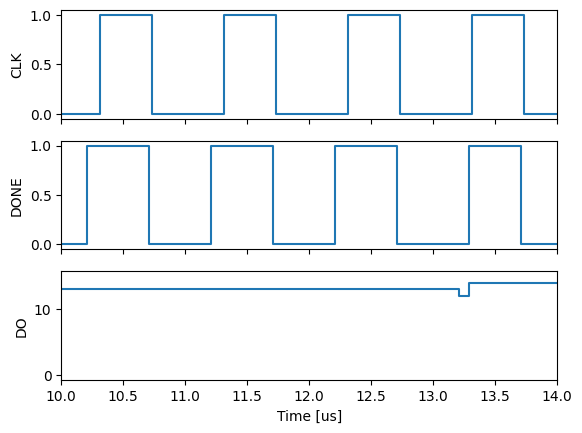

In [10]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots(3,1,sharex=True)
ax[0].step(df.us,df["CLK"])
ax[0].set_ylabel("CLK")
ax[1].step(df.us,df["DONE"])
ax[1].set_ylabel("DONE")
ax[2].step(df.us,df["RLSB"])
ax[2].set_ylabel("DO")
plt.xlabel("Time [us]")
plt.xlim(10,14)


# 2024-11-08

Got some more data from Sylvain

## Sine

In [11]:
df2 = pd.read_pickle("sar_sine_100kHz_500mV.pkl")
df2.set_index("time",inplace=True)
df2.index = pd.to_datetime(df2.index,unit='ns')
#df2["val"] = df2["val"]*10**(15.62/20)

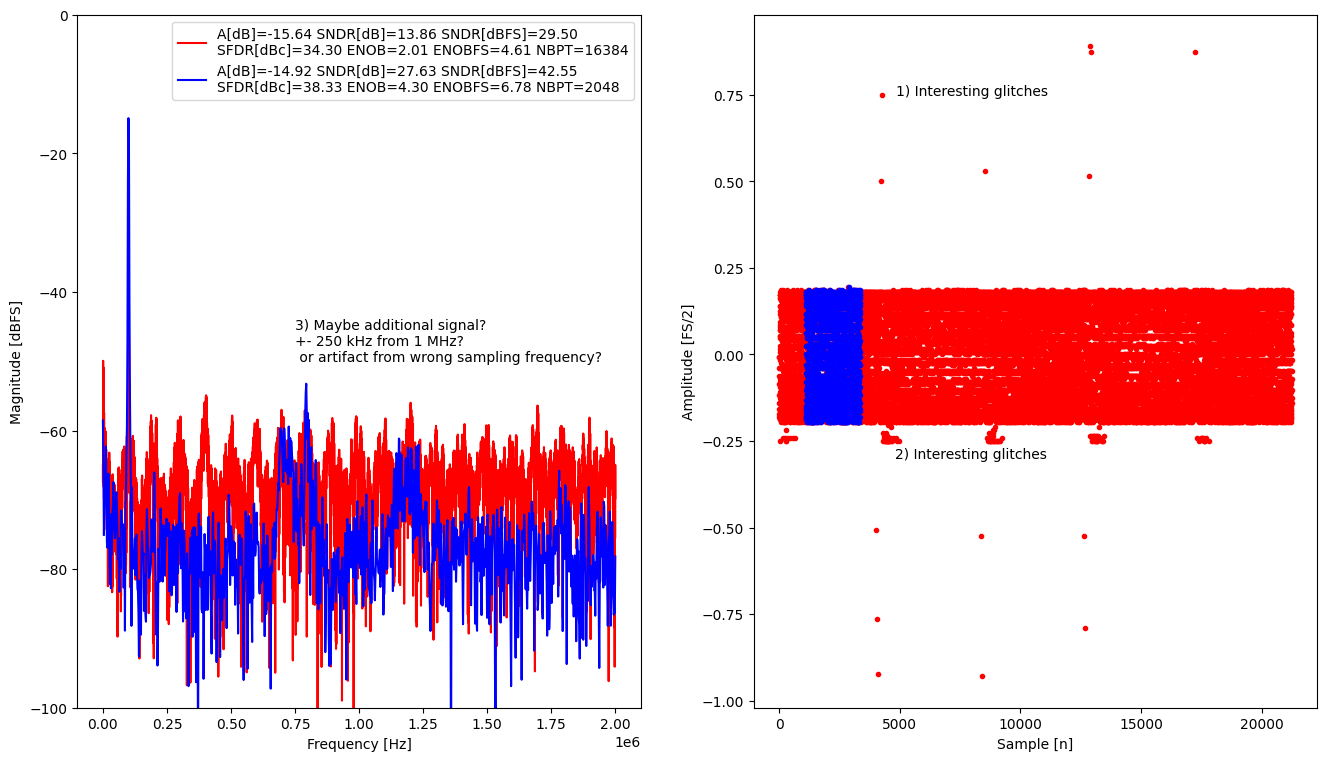

In [12]:
import cicsim as cs # I'm using latest and greatest cicsim, and if it does not work, then I might not have updated pypi
import numpy as np
def paramToStr(data):
    return "A[dB]=%.2f SNDR[dB]=%.2f SNDR[dBFS]=%.2f\nSFDR[dBc]=%.2f ENOB=%.2f ENOBFS=%.2f NBPT=%d" %(data["amp"],data["sndr"],data["sndrfs"],data["sfdr"],data["enob"],data["enobfs"],data["nbpt"])

def calc(df,tsample,name,start=0,end=None):
    if(end is not None):
        o = df[name].iloc[start:end]
    else:
        o = df[name].iloc[start:]
    oxx =  o.resample(pd.Timedelta(tsample,unit="ns")).first().ffill()
    scc = cs.SimCalc()
    data = None
    ydB = None
    (data,ydB)   = scc.fftWithHanning(oxx.to_numpy())
    x = np.linspace(0,0.5*1/(tsample*1e-9),num=int(data["nbpt"]/2))
    return (data,ydB,oxx,x)

def plotFFT(dfa, ax,color,start=0,end=None):
    tsample = 250
    data,yff,y,x = calc(dfa,tsample,"val",start=start,end=end)
    ax[0].plot(x,yff,label=paramToStr(data),color=color)
    t = np.linspace(0,len(y),num=len(y)) + start
    ax[1].plot(t,y,marker=".",linestyle="",color=color)

fig,ax = plt.subplots(1,2,figsize=(16,9))
plotFFT(df2,ax,"red")
t0 = 1100
plotFFT(df2,ax,"blue",start=t0,end=t0+2050)

ax[0].set_xlabel("Frequency [Hz]")
ax[0].set_ylabel("Magnitude [dBFS]")
ax[1].set_xlabel("Sample [n]")
ax[1].set_ylabel("Amplitude [FS/2]")
ax[0].set_ylim(-100,0)
ax[1].text(4850,0.75,"1) Interesting glitches")
ax[1].text(4800,-0.30,"2) Interesting glitches")
ax[0].text(0.75e6,-50,"3) Maybe additional signal? \n+- 250 kHz from 1 MHz? \n or artifact from wrong sampling frequency?")
ax[0].legend()

### Suggested improvements
- The funky harmonics could be kickback, but 1) 2) and 3) looks more like some interference signal. Last time I saw this it helped to have 10 pF 1% caps between the inputs, and to ground [https://analogcmos.wordpress.com](https://analogcmos.wordpress.com)
- Not sure I got the sampling correct. I should really check the digital when done falls. The noise profile has a sinc shape, which suggests I have too many points in my FFT
- Should use coherent sampling to ensure all codes are exercised. Use 2^N points (ensured by the FFT), and select a odd number FFT bin for the input signal. See example below


In [13]:
#- Picking input frequency. Since nbpt is 2**N, then any odd number will give a relative prime.
nbpt = 2**10
fin = 100e3
fs = 4e6
fbin = np.round(nbpt*fin/fs)
if(fbin % 2 == 0):
    fbin =fbin-1
print("f_in = %.2f Hz , f_bin = %d " % (fbin/nbpt*fs,fbin))

f_in = 97656.25 Hz , f_bin = 25 


## Noise

The noise level seems OK. 7 ENOB referred to full scale does not sound too bad.

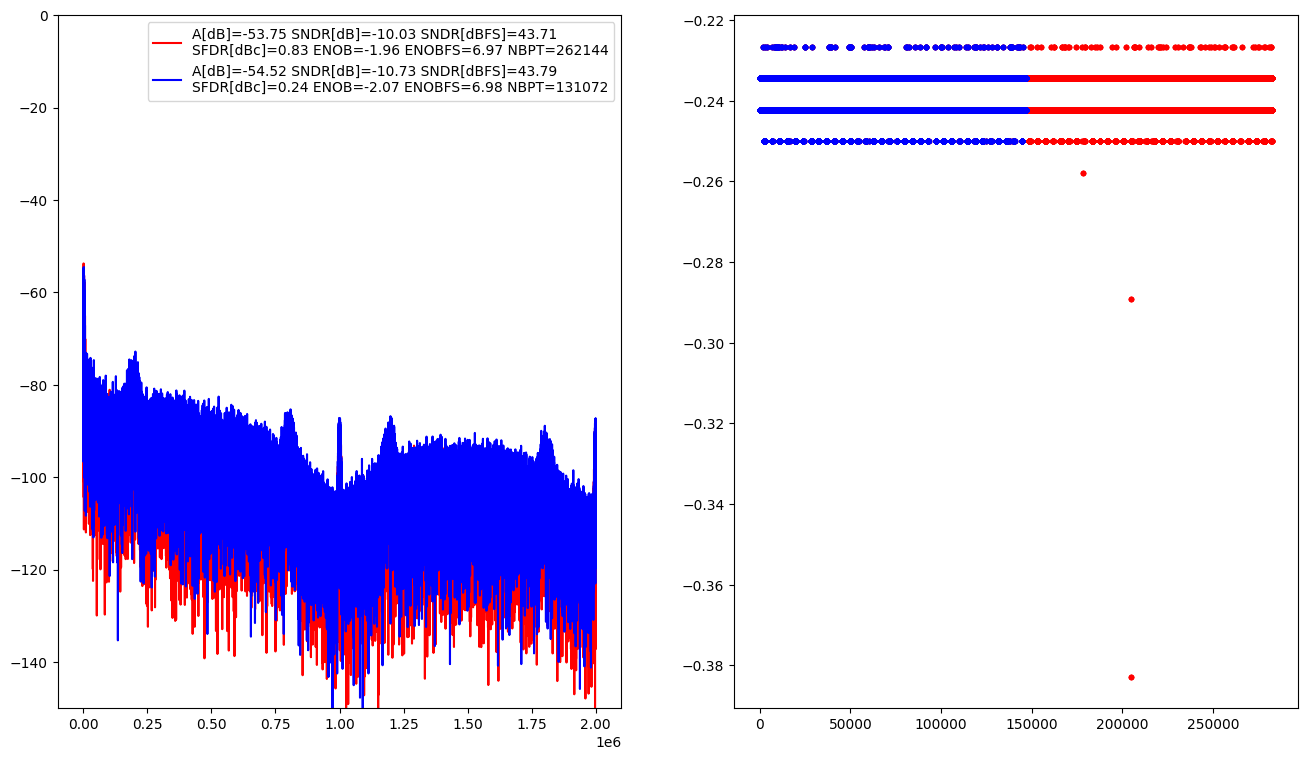

In [14]:

df3 = pd.read_pickle("sar_idle.pkl")
df3.set_index("time",inplace=True)
df3.index = pd.to_datetime(df3.index,unit='ns')
fig,ax = plt.subplots(1,2,figsize=(16,9))
plotFFT(df3,ax,"red")
plotFFT(df3,ax,"blue",start=0,end=12000)

#ax[0].plot(x,yff,label=paramToStr(data))
#ax[1].plot(y)
ax[0].set_ylim(-150,0)
ax[0].legend()

# 2025-01-11

First looks at my own PCB

STD 30.84480523274463
MEAN -0.07378078685151736


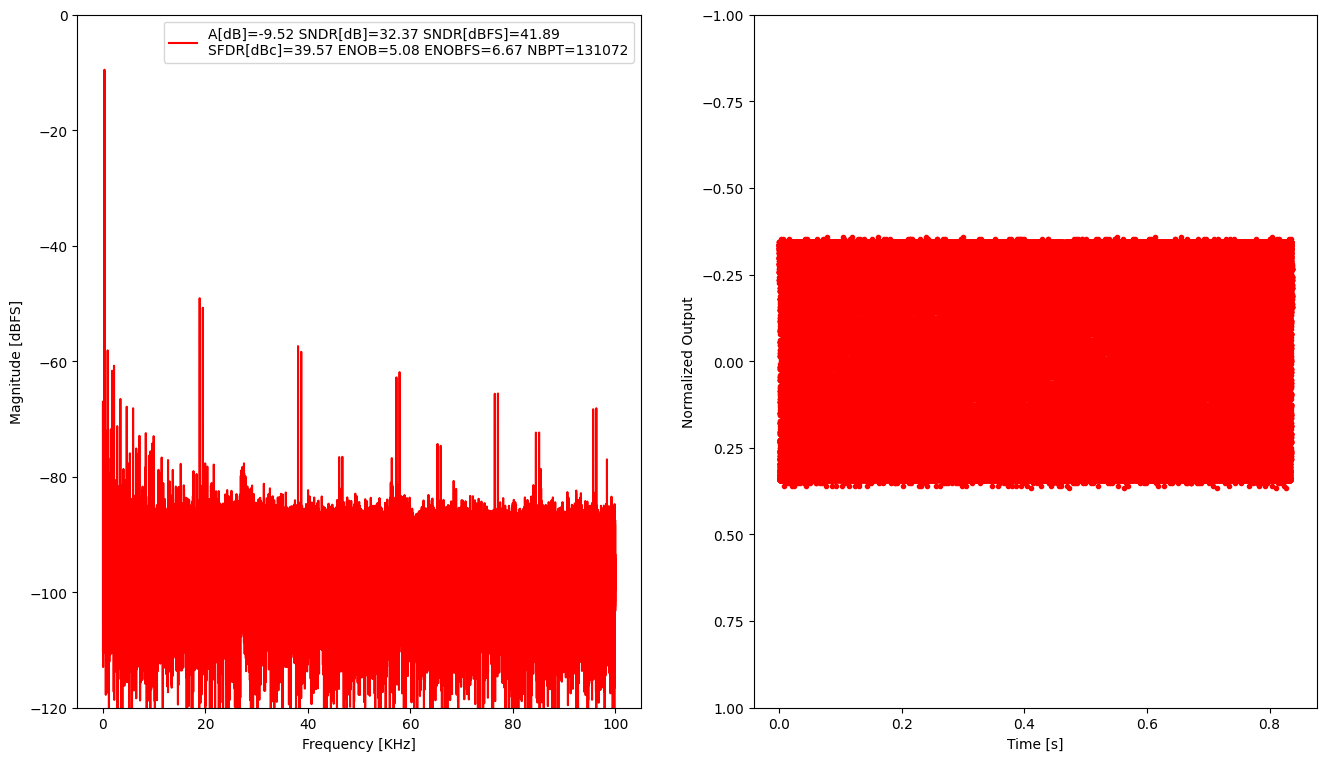

In [45]:
#df4 = pd.read_csv("2025-01-11_test2.csv")
#df4 = pd.read_csv("2025-01-11_floating_n.csv")
#df4 = pd.read_csv("2025-01-11_8MHz.csv")
#df4 = pd.read_csv("2025-01-12_1KHz_VIP.csv")
#os.chdir("meas")
df4 = pd.read_csv("2025-01-15_a0d1_1d5kHz_s1MHz.csv")

fs = 200e3
def toTwosComplement(data):
    if(data > 127):
        data = data - 256
    return data

df4["val"] = df4["Value"].apply(toTwosComplement)
df4["time"] = df4["Time [s]"]
df4.set_index("time",inplace=True)
df4.index = pd.to_datetime(df4.index,unit='s')

fig,ax = plt.subplots(1,2,figsize=(16,9))
scc = cs.SimCalc()
y = df4["val"]/128
print("STD",df4["val"].std())
print("MEAN",df4["val"].mean())
(data,ydB)   = scc.fftWithHanning(y.to_numpy())
f = np.linspace(0,0.5,num=int(len(ydB)))*fs/1e3
ax[0].plot(f,ydB,label=paramToStr(data),color="red")
t = np.linspace(0,len(y),num=len(y))/fs
ax[1].plot(t,y,marker=".",linestyle="",color="red")
ax[1].set_ylim(1,-1)
ax[1].set_ylabel("Normalized Output")
ax[1].set_xlabel("Time [s]")
ax[0].set_ylabel("Magnitude [dBFS]")
ax[0].set_xlabel("Frequency [KHz]")
#plotFFT(df4,ax,"red")
ax[0].set_ylim(-120,0)
ax[0].legend()

STD 0.3370611372507493
MEAN -0.011953275410815


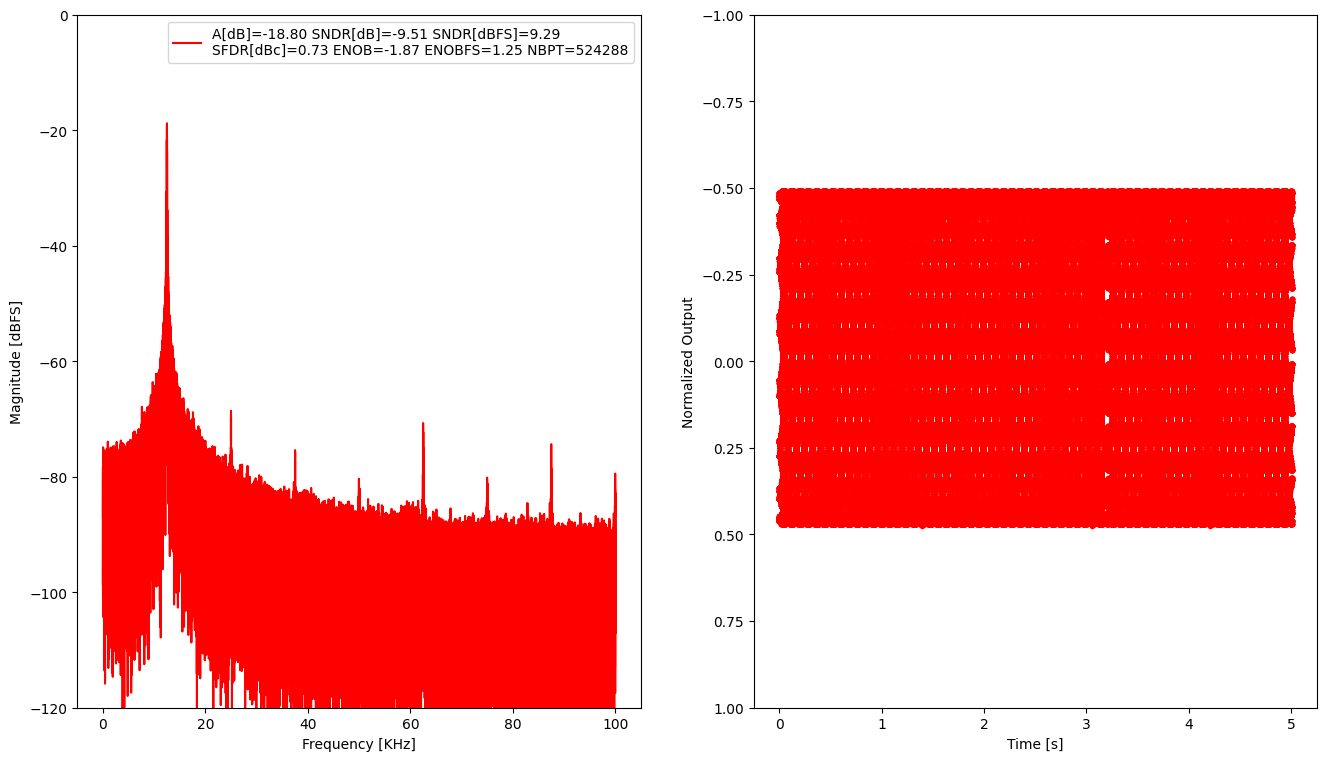

In [44]:
fname = "sylvain/adc_1250mV_1000mV.bin"

with open(fname,"rb") as fi:
    data = fi.read()

y = np.array(list(map(toTwosComplement,list(data))))
fig,ax = plt.subplots(1,2,figsize=(16,9))
scc = cs.SimCalc()
y = y/128
print("STD",y.std())
print("MEAN",y.mean())
(data,ydB)   = scc.fftWithHanning(y)
f = np.linspace(0,0.5,num=int(len(ydB)))*fs/1e3
ax[0].plot(f,ydB,label=paramToStr(data),color="red")
t = np.linspace(0,len(y),num=len(y))/fs
ax[1].plot(t,y,marker=".",linestyle="",color="red")
ax[1].set_ylim(1,-1)
ax[1].set_ylabel("Normalized Output")
ax[1].set_xlabel("Time [s]")
ax[0].set_ylabel("Magnitude [dBFS]")
ax[0].set_xlabel("Frequency [KHz]")
#plotFFT(df4,ax,"red")
ax[0].set_ylim(-120,0)
ax[0].legend()